<a href="https://colab.research.google.com/github/aryannuka/data-science/blob/main/Unit4ExerciesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm

# Unit 4 Exercises: Tinkering Hierarchical Models

These exercises are designed to force you to look at the nuances of the models we looked at in class, while exploring some "what ifs". There's also some mild data wrangling for you to enjoy at in task6.



**Task1**:

Redo the chemical shift hierarchical model, execpt with all Student T  and Half Student T likelihood and priors.

Then, compare group posteriors of the normal chem shift model with your new Student T model using a ridge plot.

In [3]:
url_cs = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/chemical_shifts_theo_exp.csv'
cs_data = pd.read_csv(url_cs)
diff_TminusE = cs_data.theo - cs_data.exp
cs_data.insert(loc=4,column='diff_TminusE',value=diff_TminusE)
aa_encode = pd.Categorical(cs_data['aa'])
aa_encode
aa_idx = aa_encode.codes
aa_idx
aa_coords = {"aa": aa_encode.categories}
aa_coords

{'aa': Index(['ALA', 'ARG', 'ASN', 'ASP', 'GLN', 'GLU', 'GLY', 'HIS', 'ILE', 'LEU',
        'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL'],
       dtype='object')}

In [4]:
with pm.Model(coords=aa_coords) as cs_h_StudentT_model:
    μ_mu = pm.StudentT('μ_mu', mu = 0, sigma = 5, nu = 5)  #each amino acid has diff prior
    μ_sd = pm.HalfStudentT('μ_sd', sigma = 5,nu =10)
    μ_nu = pm.HalfStudentT('μ_nu', sigma = 5,nu =10)
    μ = pm.StudentT('μ',mu = μ_mu,sigma = μ_s, nu =  μ_nu,
                  dims = "aa")
    σ = pm.HalfStudentT('σ', sigma = 5,
                       nu = 10,
                      dims = "aa")
    v = pm.HalfStudentT('v', sigma = 5,
                   nu = 10,
                   dims = "aa")
    y = pm.StudentT('y',mu = μ[aa_idx],
                  sigma = σ[aa_idx],
                  nu = v[aa_idx],
                  observed = cs_data.diff_TminusE) #same as previous likelihood
    idata_cs_h_StudentT = pm.sample()

Output()

Output()

In [7]:
#Replaces all the amino acid names with a number in the variable aa_idx
aa_idx = aa_encode.codes
aa_idx

array([ 8, 17, 14, ..., 10,  5, 14], dtype=int8)

In [8]:
#stores the category names in a dictionary
#this dictionary format is required
#for pymc to properly read the categories
aa_coords = {"aa": aa_encode.categories}
aa_coords

{'aa': Index(['ALA', 'ARG', 'ASN', 'ASP', 'GLN', 'GLU', 'GLY', 'HIS', 'ILE', 'LEU',
        'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL'],
       dtype='object')}

In [9]:
with pm.Model(coords=aa_coords) as cs_Th_model:
    # hyperpriors. Notice how there's no dims argument.
    #this means that the hyperprior is shared across all amino acids
    μ_mu = pm.StudentT('μ_mu', nu = 10, mu = 0, sigma = 10)
    μ_sd = pm.HalfStudentT('μ_sd', nu = 10, sigma = 10)
    μ_nu = pm.Exponential('μ_nu', lam = 1/30)

    # priors. There is a different prior for each amino acid,
    #but now the μ priors 'talk' to one another through μ_mu and μ_sd
    N = pm.Exponential('N', lam = 1/30,
                      dims = "aa")

    μ = pm.StudentT('μ',
                  nu = μ_nu,
                  mu = μ_mu,
                  sigma = μ_sd,
                  dims = "aa")

    σ = pm.HalfStudentT('σ', nu = μ_mu, sigma = 10,
                      dims = "aa")

    #likelihood; same as before
    y = pm.StudentT('y',
                  nu = N[aa_idx],
                  mu = μ[aa_idx],
                  sigma = σ[aa_idx],
                  observed = cs_data.diff_TminusE)

    #cs for chemshift, h for heirarchical
    idata_cs_Th = pm.sample()

Output()

Output()

In [10]:
with pm.Model(coords=aa_coords) as cs_Nh_model:
    # hyperpriors. Notice how there's no dims argument.
    #this means that the hyperprior is shared across all amino acids
    μ_mu = pm.Normal('μ_mu', mu = 0, sigma = 10)
    μ_sd = pm.HalfNormal('μ_sd', sigma = 10)

    # priors. There is a different prior for each amino acid,
    #but now the μ priors 'talk' to one another through μ_mu and μ_sd
    μ = pm.Normal('μ',
                  mu = μ_mu,
                  sigma = μ_sd,
                  dims = "aa")

    σ = pm.HalfNormal('σ', sigma = 10,
                      dims = "aa")

    #likelihood; same as before
    y = pm.Normal('y',
                  mu = μ[aa_idx],
                  sigma = σ[aa_idx],
                  observed = cs_data.diff_TminusE)

    #cs for chemshift, h for heirarchical
    idata_cs_Nh = pm.sample()

Output()

Output()

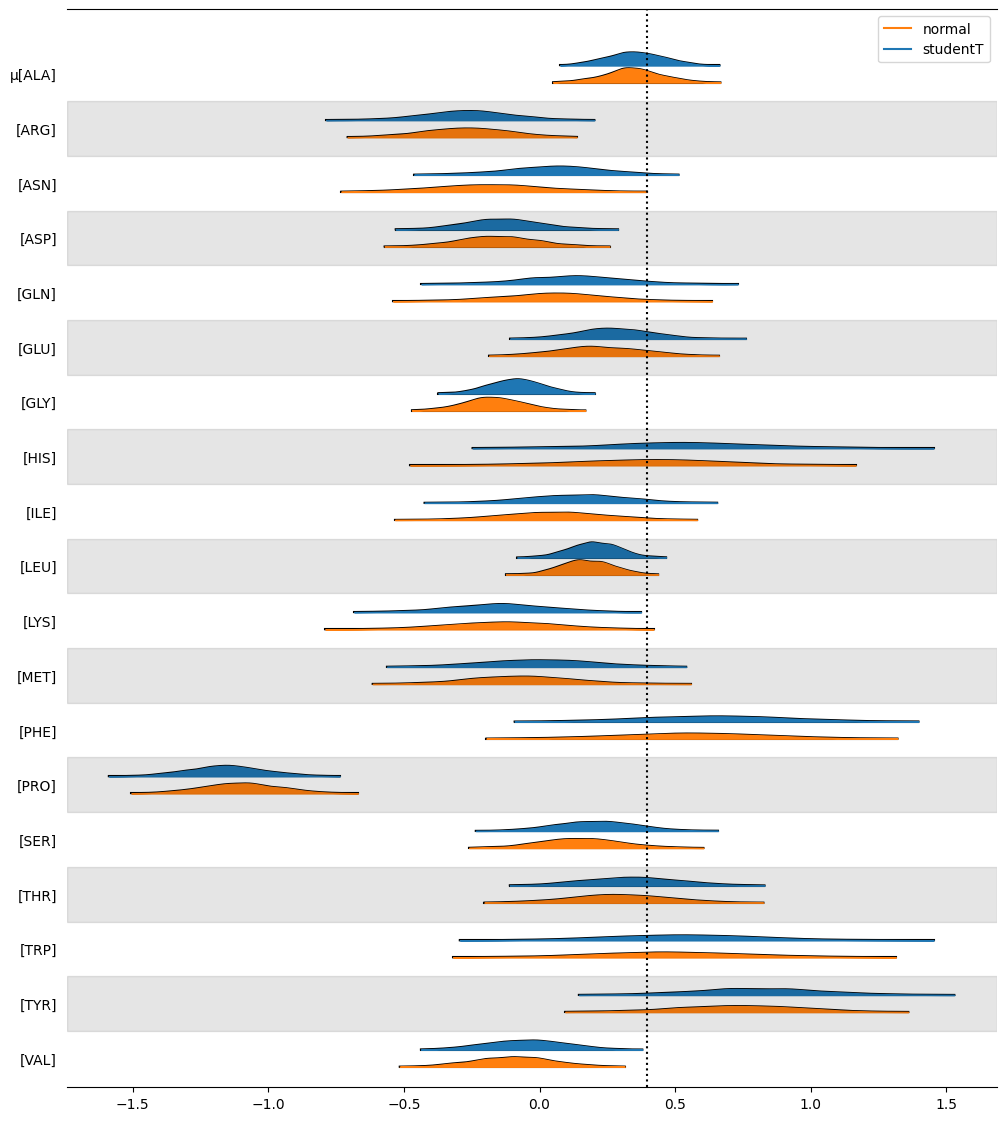

In [11]:
axes = az.plot_forest([idata_cs_Th, idata_cs_Nh], kind="ridgeplot", model_names=['studentT', 'normal'], var_names='μ', combined=True, figsize=(12, 14),hdi_prob=0.997)
y_lims = axes[0].get_ylim() axes[0].vlines(idata_cs_Th.posterior['μ_mu'].mean(), *y_lims, color="k", ls=":");

**Task2**:

Run a posterior predictive check for both models. Which seems to fit the data better?

Output()

(-10.0, 10.0)

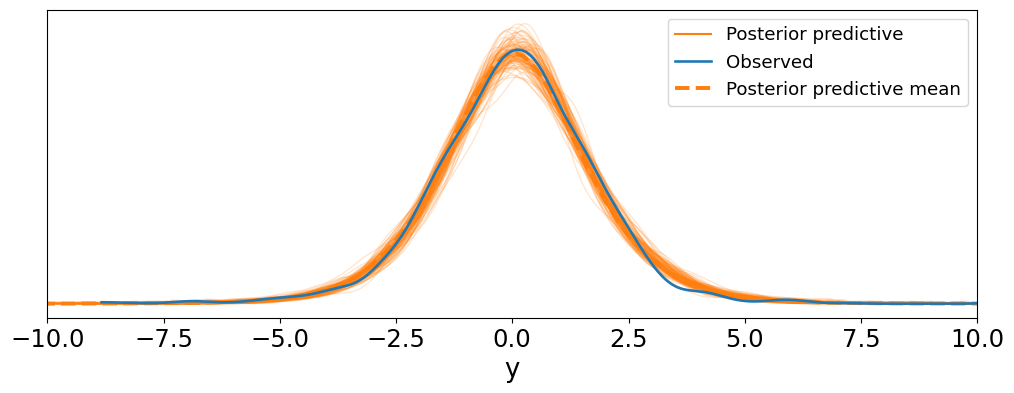

In [16]:
pm.sample_posterior_predictive(idata_cs_Th, model=cs_Th_model, extend_inferencedata=True)
ax = az.plot_ppc(idata_cs_Th, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])
ax.set_xlim(-10,10)

Output()

<bound method _AxesBase.set_xlim of <Axes: xlabel='y'>>

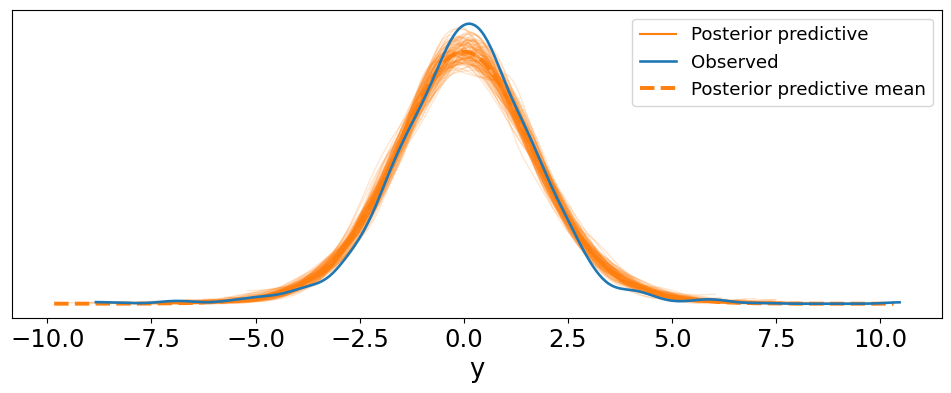

In [20]:
pm.sample_posterior_predictive(idata_cs_Nh, model=cs_Nh_model, extend_inferencedata=True)
ax = az.plot_ppc(idata_cs_Nh, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])
ax.set_xlim


Both PPCs are similar, but the Normal distribution underestimates lows and overestimates peaks, while the StudentT mainly underestimates negative y-values and overestimates positive ones. Overall, the StudentT fits the data better.

**Task3**:

Redo the soccer model, but this time, assume the groups are independent. This will be a non-hierarchical model.

In [21]:
url_sccr = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/football_players.csv'

sccr_data = pd.read_csv(url_sccr,dtype={'position':'category'}) #Makes the position column into categorical variable

pos_idx = sccr_data.position.cat.codes.values #Array of the soccer positions

pos_codes = sccr_data.position.cat.categories

sccr_coords = {"pos": pos_codes}

In [22]:
#this is an array of the soccer positions,
#except they are given an int (number) label instead of a string (of letters)
pos_idx = sccr_data.position.cat.codes.values

#an array of the four strings that represent position
pos_codes = sccr_data.position.cat.categories

#puts coords in a dict, so pymc can read them
sccr_coords = {"pos": pos_codes}

In [23]:
with pm.Model(coords = sccr_coords) as sccr_model:
    # Parameters for positions
    μ_p = pm.Beta('μ_p', mu = 0.1, nu = 45, dims = "pos")

    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")

    # Parameter for players
    θ = pm.Beta('θ', mu = μ_p[pos_idx], nu = ν_p[pos_idx])

    #This tells our model how many shots and goals each player has
    _ = pm.Binomial('gs',
                    n = sccr_data.shots.values, #shots for each player
                    p = θ, #guess of goals per shot
                    observed = sccr_data.goals.values) #goals per player

 #Increasing target_accept higher than 0.8 makes us less likely to
    idata_sccr = pm.sample(target_accept=0.95)

Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


**Task4**:

Run plot trace and rhat on your inference data object for the non-hierarchical soccer model. How does this compare to the hierarchical model?

<xarray.Dataset> Size: 43kB
Dimensions:  (θ_dim_0: 2682, pos: 4)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 21kB 0 1 2 3 4 5 ... 2676 2677 2678 2679 2680 2681
  * pos      (pos) <U2 32B 'DF' 'FW' 'GK' 'MF'
Data variables:
    θ        (θ_dim_0) float64 21kB 1.001 1.004 1.002 ... 1.004 0.9998 1.002
    μ_p      (pos) float64 32B 1.008 1.0 1.035 1.001
    ν_p      (pos) float64 32B 1.021 1.004 1.113 1.002

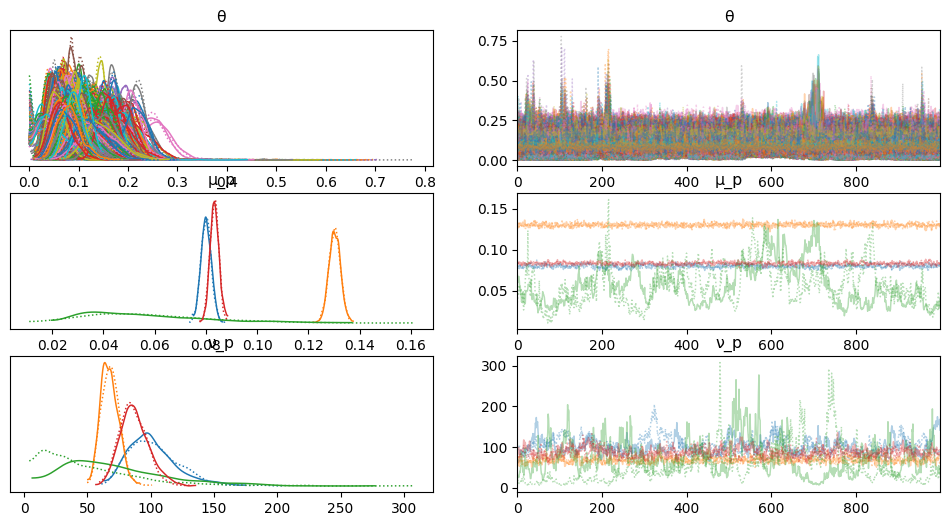

In [ ]:
az.plot_trace(idata_sccr)
az.rhat(idata_sccr)

The new non-hierarchical model shows rhat values much closer to the ideal range (1 to 1.001). While the GK value is somewhat high at 1.09, it's still an improvement over the hierarchical model's 1.242. Additionally, observed data aligns well with the plot predictions. For μ_p, the solid and dotted lines are closely matched, indicating more accurate predictions. The same applies to ν_p, though the green graph differs significantly.

**Task5**:

Plot the posterior of the means for each soccer position in the non-hierarchical model.

How do these posteriors compare to the hierarchical model we did in class?

array([<Axes: >], dtype=object)

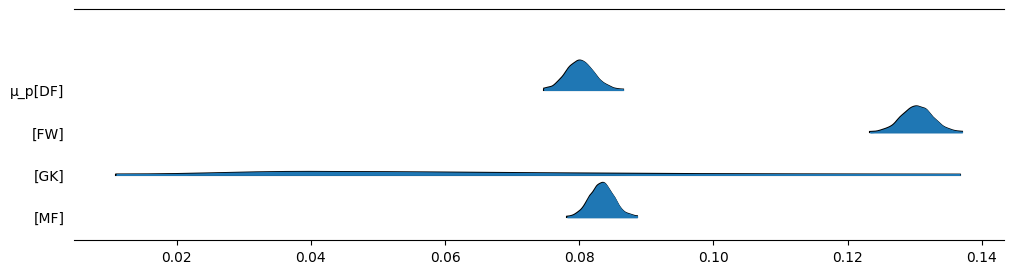

In [ ]:
az.plot_forest(idata_sccr, var_names=['μ_p'], combined=True, figsize=(12, 3), kind = 'ridgeplot', hdi_prob=0.998)

These posteriors resemble those of the hierarchical model but are smoother, indicating slightly higher accuracy.

**Task6**:

Redo the soccer model as a hierarchical model, but remove all the goalkeepers (GK) from the data. In other words, run a hierarchical model on only the defenders, midfielders, and forwards.

In [25]:
sccr_data
no_gk_data = sccr_data.loc[sccr_data["position"] != "GK"]
no_gk_data
pos_idx = no_gk_data.position.cat.codes.values
pos_codes = no_gk_data.position.cat.categories
sccr_coords_no_gk = {"pos": pos_codes}

In [26]:
with pm.Model(coords = sccr_coords_no_gk) as sccr_h_model:
    μ = pm.Beta('μ', alpha = 2, beta = 20)
    ν = pm.Gamma('ν', mu = 55, sigma = 45)
    μ_p = pm.Beta('μ_p', mu = μ, nu = ν, dims = "pos") #Parameters for position
    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")
    θ = pm.Beta('θ', mu = μ_p[pos_idx], nu = ν_p[pos_idx]) #Player parameters
#Shows how many shots and goals of each player
    _ = pm.Binomial('gs',
                    n = no_gk_data.shots.values,
                    p = θ,
                    observed = no_gk_data.goals.values)
    #target_accept has a default of 0.8. Increasing it makes it less likely to have divergences
    idata_sccr_no_gk = pm.sample(target_accept = 0.95)

Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


**Task7**:

Compare the plot trace and rhat results for the hierarchical model with GKs and without GKs. Then answer the following questions:
- Which model was easier for pymc to process?
- What do we lose by dropping Gks from the data set? What do we gain?

array([<Axes: >], dtype=object)

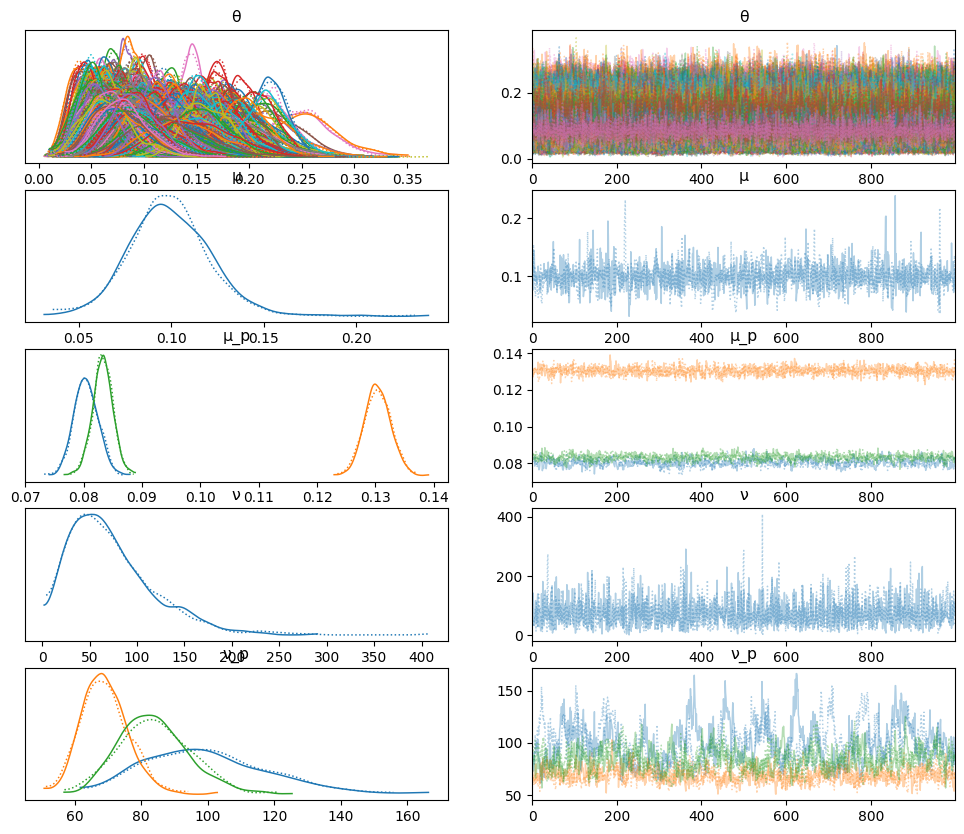

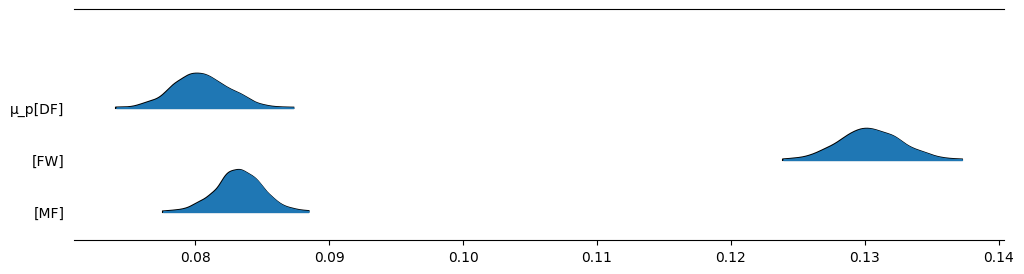

In [ ]:
az.plot_trace(idata_sccr_noGK)
az.rhat(idata_sccr_noGK)
az.plot_forest(idata_sccr_noGK, var_names=['μ_p'], combined=True, figsize=(12, 3), kind = 'ridgeplot', hdi_prob=0.998)

Excluding the GKs makes the model more compact, easier to interpret, and reduces processing time by about half, as there’s less data. Although it loses potential GK scoring data, this rarely impacts the model since GKs seldom score and tend to skew results. Removing GKs slightly hinders GK shot ratio prediction but improves clarity and speed for other positions. Overall, the model without GKs better suits our goals.